In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import nltk, re, time
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer

nltk.download('stopwords')

Using TensorFlow backend.


[nltk_data] Downloading package stopwords to /home/ideis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
data = pd.read_csv("data/labeledTrainData.tsv", delimiter="\t")
data.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


In [3]:
def clean_text(text, remove_stopwords=True):
    '''Clean the text, with the option to remove stopwords'''
    
    text = text.lower().split()

    # Optionally, remove stop words
    if remove_stopwords:
        stops = set(stopwords.words("russian"))
        text = [w for w in text if not w in stops]
    
    text = " ".join(text)

    text = re.sub(r"<br />", " ", text)
    text = re.sub(r"[^a-z]", " ", text)
    text = re.sub(r"   ", " ", text) # Remove any extra spaces
    text = re.sub(r"  ", " ", text)
    
    return(text)

data['review'] = data.apply(lambda x: clean_text(x['review']), axis=1)

In [4]:
def split_data(data, labels, train_test_split=0.8):
    data_size = len(data)
    test_size = int(data_size - round(data_size * train_test_split))
    
    print("\nTraining set:")
    X_train = data[test_size:]
    print("  X_train: {}".format(len(X_train)))
    y_train = labels[test_size:]
    print("  y_train: {}".format(len(y_train)))
    
    print("\nTesting set:")
    X_test = data[:test_size]
    print("  X_test: {}".format(len(X_test)))
    y_test = labels[:test_size]
    print("  y_test: {}".format(len(y_test)))

    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = split_data(data, data['sentiment'])


Training set:
  X_train: 20000
  y_train: 20000

Testing set:
  X_test: 5000
  y_test: 5000


In [5]:
# Tokenize the reviews
num_words = 1000

all_reviews = data['review']
all_reviews.head()
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(all_reviews)

total_words = len(tokenizer.word_index)
print('{} words in a dictionary'.format(total_words))

X_train = tokenizer.texts_to_matrix(X_train['review'])
X_test = tokenizer.texts_to_matrix(X_test['review'])


73272 words in a dictionary


In [6]:
from keras.utils import to_categorical
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(20000, 1000)
(20000, 2)
(5000, 1000)
(5000, 2)


In [7]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Activation
from keras.layers import Dropout

model = Sequential()
model.add(Dense(64, input_shape=(num_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.2))
model.add(Dense(2))
model.add(Activation('sigmoid'))

model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [8]:
history = model.fit(X_train, y_train,
                    batch_size=32,
                    epochs=15,
                    verbose=1,
                    validation_split=0.1)

Train on 18000 samples, validate on 2000 samples
Epoch 1/15
18000/18000 [==============================] - 2s 105us/step - loss: 0.4358 - acc: 0.7982 - val_loss: 0.3230 - val_acc: 0.8640
Epoch 2/15
18000/18000 [==============================] - 2s 100us/step - loss: 0.3269 - acc: 0.8612 - val_loss: 0.3123 - val_acc: 0.8635
Epoch 3/15
18000/18000 [==============================] - 2s 93us/step - loss: 0.2888 - acc: 0.8802 - val_loss: 0.3231 - val_acc: 0.8610
Epoch 4/15
18000/18000 [==============================] - 2s 93us/step - loss: 0.2519 - acc: 0.8997 - val_loss: 0.3383 - val_acc: 0.8595
Epoch 5/15
18000/18000 [==============================] - 2s 93us/step - loss: 0.2102 - acc: 0.9204 - val_loss: 0.3507 - val_acc: 0.8555
Epoch 6/15
18000/18000 [==============================] - 2s 94us/step - loss: 0.1598 - acc: 0.9399 - val_loss: 0.3932 - val_acc: 0.8495
Epoch 7/15
18000/18000 [==============================] - 2s 94us/step - loss: 0.1244 - acc: 0.9553 - val_loss: 0.4434 - val_ac

In [9]:
score = model.evaluate(X_test, y_test,
                       batch_size=32, verbose=1)
print()
print(u'Test accuracy: {}'.format(score[0]))
print(u'Model accuracy: {}'.format(score[1]))

5000/5000 [==============================] - 0s 38us/step

Test accuracy: 0.7643198522090912
Model accuracy: 0.8294


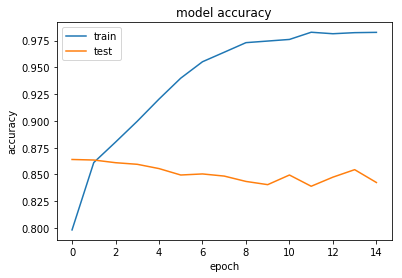

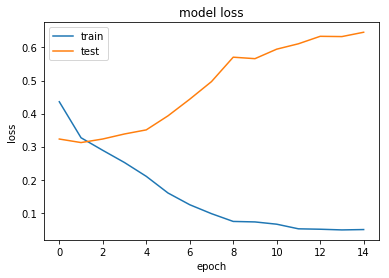

In [10]:
import matplotlib.pyplot as plt

# Accuracy graph
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# Loss graph
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()